In [3]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import pandas as pd

In [4]:
df = pd.read_csv('/home/jdh/文档/archive/twitter_training.csv', header=None)
print('数据量：', len(df))
df.columns = ['id', 'topic', 'sentiment', 'text']
print(df.head())

数据量： 74682
     id        topic sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                                text  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  


In [ ]:
df.info()

In [6]:
import collections
cnt = collections.Counter(df['sentiment'].tolist())
print(cnt)

Counter({'Negative': 22542, 'Positive': 20832, 'Neutral': 18318, 'Irrelevant': 12990})


In [7]:
length = [len(str(li).strip().split()) for li in df['text']]
print(min(length))
print(max(length))
print(sum(length)/len(length))

0
198
19.05919766476527


In [8]:
def word_count(sentence):
    return len(str(sentence).strip().split())
print(len(df))
df = df[df['text'].apply(word_count) >= 3]
print(len(df))

74682
69571


In [9]:
label_dic = {'Negative': 0, 'Positive': 1, 'Neutral': 2, 'Irrelevant': 3}
df['sentiment'] = df['sentiment'].apply(lambda x: label_dic[x])

In [11]:
class taskDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        inputs= self.tokenizer.encode_plus(
                self.data[idx],
                None,
                max_length=30,
                truncation=True,
                pad_to_max_length=True,
            
            )
        ids=inputs['input_ids']
        mask=inputs['attention_mask']
        tt_ids=inputs['token_type_ids']


        return torch.tensor(ids, dtype=torch.long), torch.tensor(mask, dtype=torch.long), torch.tensor(tt_ids, dtype=torch.long),\
                torch.tensor(self.label[idx], dtype=torch.long)


class taskModel(nn.Module):
    def __init__(self, output_size):
        super(taskModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_size)
        self.drop = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, ids, mask, tt_ids):
        _,x = self.bert(ids, mask, tt_ids, return_dict=False)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.fc3(x)

        return x

In [20]:
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('/home/jdh/文档/bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('/home/jdh/文档/bert-base-uncased')
texts, labels = df['text'].tolist(), df['sentiment'].tolist()
dataset = taskDataset(texts, labels)
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /home/jdh/文档/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# 计算类别权重
class_counts = torch.bincount(torch.tensor(labels))
print(class_counts)
class_weights = 1.0 / class_counts.float()
print(class_weights)

tensor([21074, 19013, 17244, 12240])
tensor([4.7452e-05, 5.2596e-05, 5.7991e-05, 8.1699e-05])


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
model = taskModel(4)
model.to(device)
for name, params in model.named_parameters():
    params.requires_grad = False
    if 'fc' in name or 'layer.11' in name:
        params.requires_grad = True
        print(name, len(params))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion.to(device)

In [23]:
from tqdm import tqdm

epochs = 20
model.train()
best_loss = int(1e9)
for epoch in range(epochs):
    total_loss = 0
    for ids, mask, tt_ids, lab in tqdm(data_loader):
        ids = ids.to(device)
        mask = mask.to(device)
        tt_ids = tt_ids.to(device)
        
        output = model(ids, mask, tt_ids)
        output = output.to(device)
        optimizer.zero_grad()
        loss = criterion(output, lab.to(device))
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    if total_loss/len(data_loader)<best_loss:
        best_model = model
    print(f'Epoch: {epoch}, Loss: {total_loss/len(data_loader)}')
model = best_model

  0%|          | 0/4349 [00:00<?, ?it/s]/home/jdh/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 4349/4349 [36:31<00:00,  1.98it/s]


Epoch: 0, Loss: 1.2119007085377826


100%|██████████| 4349/4349 [35:22<00:00,  2.05it/s]


Epoch: 1, Loss: 1.1254201218379616


100%|██████████| 4349/4349 [34:15<00:00,  2.12it/s]


Epoch: 2, Loss: 1.1039062742667243


100%|██████████| 4349/4349 [34:16<00:00,  2.11it/s]


Epoch: 3, Loss: 1.0753460924881413


100%|██████████| 4349/4349 [34:10<00:00,  2.12it/s]


Epoch: 4, Loss: 1.0416399803921446


100%|██████████| 4349/4349 [33:57<00:00,  2.13it/s]


Epoch: 5, Loss: 1.0130779251308928


100%|██████████| 4349/4349 [33:44<00:00,  2.15it/s]


Epoch: 6, Loss: 0.996800498356351


100%|██████████| 4349/4349 [34:47<00:00,  2.08it/s]


Epoch: 7, Loss: 0.9853949663857806


100%|██████████| 4349/4349 [34:35<00:00,  2.10it/s]


Epoch: 8, Loss: 0.972772134141172


100%|██████████| 4349/4349 [34:34<00:00,  2.10it/s]


Epoch: 9, Loss: 0.9559060221884437


100%|██████████| 4349/4349 [34:11<00:00,  2.12it/s]


Epoch: 10, Loss: 0.9433672643099799


100%|██████████| 4349/4349 [33:50<00:00,  2.14it/s]


Epoch: 11, Loss: 0.9351750815372463


100%|██████████| 4349/4349 [33:53<00:00,  2.14it/s]


Epoch: 12, Loss: 0.9298957609587577


100%|██████████| 4349/4349 [33:35<00:00,  2.16it/s]


Epoch: 13, Loss: 0.9287160078899206


100%|██████████| 4349/4349 [33:24<00:00,  2.17it/s]


Epoch: 14, Loss: 0.9217386098257782


100%|██████████| 4349/4349 [33:31<00:00,  2.16it/s]


Epoch: 15, Loss: 0.9152936282980768


100%|██████████| 4349/4349 [33:30<00:00,  2.16it/s]


Epoch: 16, Loss: 0.9000455114547619


100%|██████████| 4349/4349 [33:23<00:00,  2.17it/s]


Epoch: 17, Loss: 0.8953773157401698


100%|██████████| 4349/4349 [33:12<00:00,  2.18it/s]


Epoch: 18, Loss: 0.8833392738035065


100%|██████████| 4349/4349 [33:09<00:00,  2.19it/s]

Epoch: 19, Loss: 0.8833385195217343


In [28]:
import numpy as np
test_df = pd.read_csv('/home/jdh/文档/archive/twitter_validation.csv', header=None)
test_df.columns = ['id', 'topic', 'sentiment', 'text']
test_df['sentiment'] = test_df['sentiment'].apply(lambda x: label_dic[x])

model.eval()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
predictions = []
with torch.no_grad():
    for text in test_df['text'].values:
        inputs = tokenizer.encode_plus(
                text,
                None,
                max_length=30,
                truncation=True,
                padding=True,
            
            )
        ids = torch.tensor([inputs['input_ids']], dtype=torch.long)
        mask = torch.tensor([inputs['attention_mask']], dtype=torch.long)
        tt_ids = torch.tensor([inputs['token_type_ids']], dtype=torch.long)
        ids = ids.to(device)
        mask = mask.to(device)
        tt_ids = tt_ids.to(device)
        pred = model(ids, mask, tt_ids)
        predictions.append(np.argmax(pred[0].cpu().numpy()))

from sklearn.metrics import precision_score, recall_score, f1_score
test_labels = test_df['sentiment'].tolist()
print('prec:', precision_score(test_labels, predictions, average='macro'))
print('rec:', recall_score(test_labels, predictions, average='macro'))
print('f1:', f1_score(test_labels, predictions, average='macro'))

prec: 0.7352423824186716
rec: 0.7452615171755264
f1: 0.7334875767719772


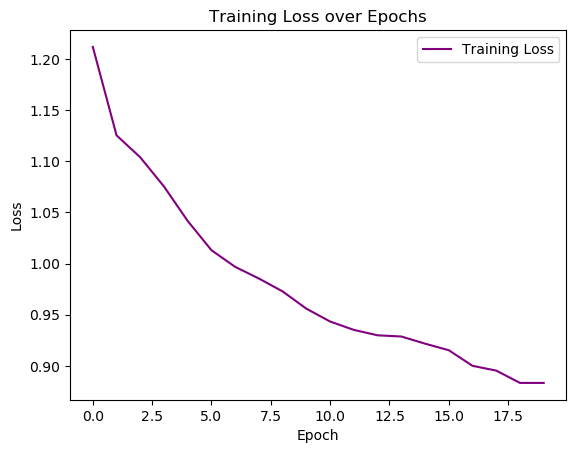

In [58]:
import matplotlib.pyplot as plt

# 假设你已经在训练过程中记录了每个 epoch 的训练损失
train_losses = [1.2119007085377826, 1.1254201218379616, 1.1039062742667243, 1.0753460924881413, 1.0416399803921446,1.0130779251308928,
                0.996800498356351,0.9853949663857806,0.972772134141172,0.9559060221884437,0.9433672643099799,0.9351750815372463,0.9298957609587577,
                0.9287160078899206,0.9217386098257782,0.9152936282980768,0.9000455114547619,0.8953773157401698,0.8833392738035065,0.8833385195217343]  # 例子中的损失列表
epochs = len(train_losses)  # 训练的轮次

# 绘制训练损失随时间变化的图表
plt.plot(range(epochs), train_losses, color='purple',label='Training Loss')

# 添加标签、标题和图例
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()  # 显示标签

# 显示图表
plt.show()



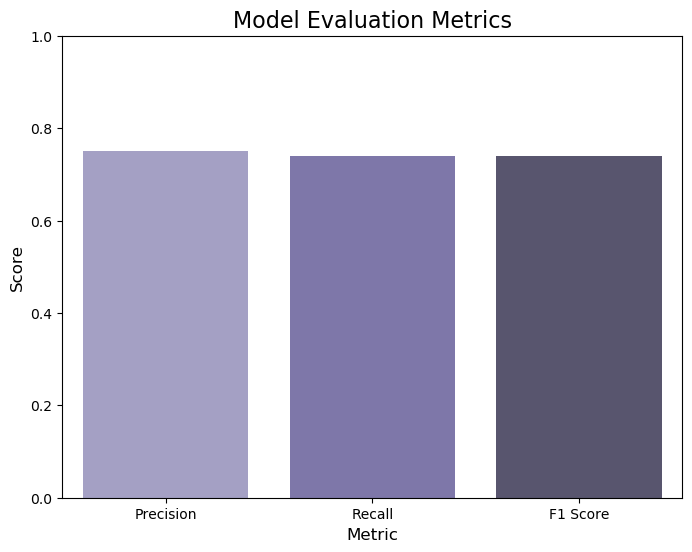

In [49]:
import seaborn as sns

# 我们已经计算出这三个指标
precision = 0.75
recall = 0.74
f1 = 0.74

# 创建一个字典，存储这些指标
metrics = {'Precision': precision, 'Recall': recall, 'F1 Score': f1}

# 转换为列表
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# 创建数据框，用于传递给 seaborn
import pandas as pd
df_metrics = pd.DataFrame({
    'Metric': metric_names,
    'Score': metric_values
})

# 使用 seaborn 绘制条形图，解决FutureWarning
plt.figure(figsize=(8, 6))
sns.barplot(x='Metric', y='Score', data=df_metrics, hue='Metric', palette='Purples_d', dodge=False)

# 添加标题和标签
plt.title('Model Evaluation Metrics', fontsize=16)
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1)  # 设置y轴范围从0到1，适合百分比指标

# 显示图形
plt.show()


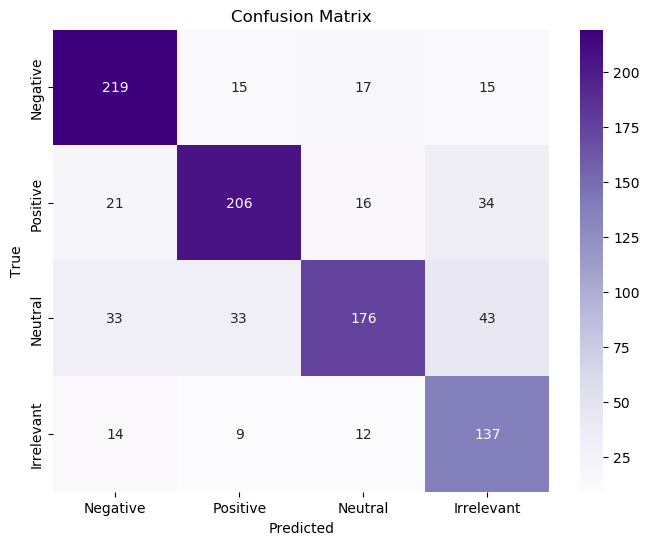

In [47]:
cm = confusion_matrix(test_labels, predictions)

# 绘制热图
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=label_dic.keys(), yticklabels=label_dic.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

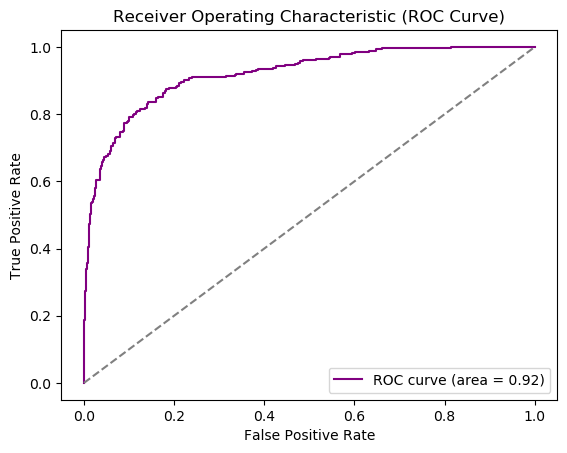

In [57]:
from sklearn.metrics import roc_curve, auc

# 1. 计算每个样本的预测概率
model.eval()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
predictions = []
model_probs = []

with torch.no_grad():
    for text in test_df['text'].values:
        inputs = tokenizer.encode_plus(
                text,
                None,
                max_length=30,
                truncation=True,
                padding=True,
            )
        ids = torch.tensor([inputs['input_ids']], dtype=torch.long)
        mask = torch.tensor([inputs['attention_mask']], dtype=torch.long)
        tt_ids = torch.tensor([inputs['token_type_ids']], dtype=torch.long)
        ids = ids.to(device)
        mask = mask.to(device)
        tt_ids = tt_ids.to(device)
        
        # 获取模型输出 logits
        logits = model(ids, mask, tt_ids)
        
        # 将 logits 转换为概率分布
        probs = torch.nn.functional.softmax(logits, dim=-1)
        
        # 将每个样本的概率保存下来
        model_probs.append(probs[0].cpu().numpy())  # 保存每个样本的概率
        
        # 获取预测类别
        predictions.append(np.argmax(probs[0].cpu().numpy()))  # 获取类别标签

# 2. 计算 ROC 曲线
model_probs = np.array(model_probs)

# 假设是多分类问题，选择对每个类别绘制 ROC 曲线
# 选择目标类别的概率（这里以类 1 为例）
# 如果是二分类，可以直接选择阳性类的概率
positive_class_probs = model_probs[:, 1]  # 如果是二分类，选择第 1 列作为阳性类概率

# 获取真实标签
test_labels = test_df['sentiment'].tolist()

# 计算 ROC 曲线
fpr, tpr, thresholds = roc_curve(test_labels, positive_class_probs, pos_label=1)

# 计算 AUC
roc_auc = auc(fpr, tpr)

# 3. 绘制 ROC 曲线
plt.figure()
plt.plot(fpr, tpr, color='purple', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC Curve)')
plt.legend(loc='lower right')
plt.show()


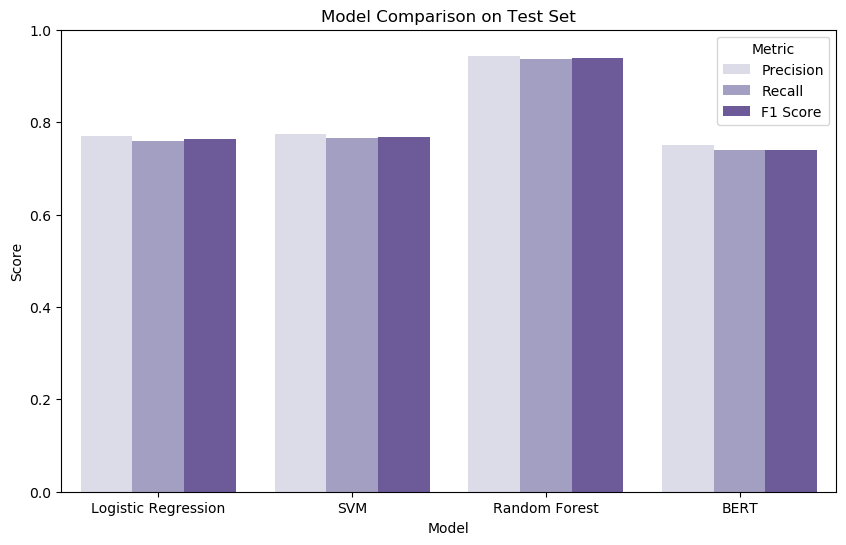

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. 特征提取
vectorizer = TfidfVectorizer(max_features=3000)
X_train = vectorizer.fit_transform(texts)
y_train = labels
X_test = vectorizer.transform(test_df['text'])
y_test = test_df['sentiment']

# 2. 训练与评估
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': LinearSVC(dual='auto'),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

results = {}
for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    results[name] = {
        'Precision': precision_score(y_test, y_pred, average='macro'),
        'Recall': recall_score(y_test, y_pred, average='macro'),
        'F1 Score': f1_score(y_test, y_pred, average='macro')
    }

# 加入BERT模型结果
results['BERT'] = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}
dual='auto'
import seaborn as sns
import pandas as pd

df_results = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})
df_results = pd.melt(df_results, id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=df_results, palette='Purples')
plt.title('Model Comparison on Test Set')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metric')
plt.show()